# CottonWeed15 - MobileNetV3Small

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
import shutil

seed = 999
def seedEverything(seed, deterministic = False):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    tf.keras.utils.set_random_seed(seed)

    if deterministic:
        print("Running Deterministically")
        tf.config.experimental.enable_op_determinism()

        os.environ['TF_DETERMINISTIC_OPS'] = '1'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

        #tf.config.threading.set_inter_op_parallelism_threads(1)
        #tf.config.threading.set_intra_op_parallelism_threads(1)


seedEverything(seed, True)

2024-05-31 12:24:04.497953: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 12:24:04.498042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 12:24:04.633366: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Running Deterministically


In [2]:
# ! pip install kagglehub --upgrade --q

# import kagglehub
# print(kagglehub.__version__)

# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# key = user_secrets.get_secret("kaggle_token")

# kagglehub.auth.set_kaggle_credentials('reganmaharjan',key)

In [3]:
## Downloading DeepWeeds Data  ## For Google Colab
# url = 'https://drive.google.com/uc?export=download&id=1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj'
# !gdown 1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj
# !unzip -qq images.zip -d images

In [4]:
# data_info = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/labels.csv') ## for GoogleColab
data_info = pd.read_csv("/kaggle/input/cottonweed15-downsampled/labels.csv") ## For Kaggle
data_info = data_info[['img', 'label']]
data_info

,img,label
0,351b9a52aaaf40f592557cca89a902a5__nutsedge__0.jpg,Nutsedge
1,992b7dca6928459e85aafbf945585dd0__nutsedge__7.jpg,Nutsedge
2,8803be5e86774ff1b7116d5f5a5b2727__nutsedge__0.jpg,Nutsedge
3,e1da7a5e314a41c5886b384bd69320fc__nutsedge__0.jpg,Nutsedge
4,IMG_0547.JPG,Nutsedge
...,...,...
5182,1f101adc29984ee783d36d96ad6e5b7d__purselane__2...,Purslane
5183,0001.jpg,Purslane
5184,IMG_1426.JPG,Purslane
5185,IMG_1481 (3).JPG,Purslane


In [5]:
label_counts = data_info.groupby('label').count()
label_counts.T

label,Carpetweeds,Crabgrass,Eclipta,Goosegrass,Morningglory,Nutsedge,PalmerAmaranth,Prickly Sida,Purslane,Ragweed,Sicklepod,SpottedSpurge,SpurredAnoda,Swinecress,Waterhemp
img,763,111,254,216,1115,273,689,129,450,129,240,234,61,72,451


In [6]:
# label2id = data_info['label'].unique()
# label2id = {label2id[i]:i for i in range(len(label2id))}
# id2label = {label2id[i]:i for i in label2id}
label2id = {'Nutsedge': 0, 'Sicklepod': 1, 'Morningglory': 2, 'Ragweed': 3,
            'PalmerAmaranth': 4, 'Waterhemp': 5, 'Crabgrass': 6, 'Swinecress': 7,
            'Prickly Sida': 8, 'Carpetweeds': 9, 'SpottedSpurge': 10, 'SpurredAnoda': 11,
            'Eclipta': 12, 'Goosegrass': 13, 'Purslane': 14}
id2label = {label2id[i]:i for i in label2id}
class_names = [id2label[i] for i in range(len(label2id))]

print(id2label)
print(label2id)
print(class_names)

{0: 'Nutsedge', 1: 'Sicklepod', 2: 'Morningglory', 3: 'Ragweed', 4: 'PalmerAmaranth', 5: 'Waterhemp', 6: 'Crabgrass', 7: 'Swinecress', 8: 'Prickly Sida', 9: 'Carpetweeds', 10: 'SpottedSpurge', 11: 'SpurredAnoda', 12: 'Eclipta', 13: 'Goosegrass', 14: 'Purslane'}
{'Nutsedge': 0, 'Sicklepod': 1, 'Morningglory': 2, 'Ragweed': 3, 'PalmerAmaranth': 4, 'Waterhemp': 5, 'Crabgrass': 6, 'Swinecress': 7, 'Prickly Sida': 8, 'Carpetweeds': 9, 'SpottedSpurge': 10, 'SpurredAnoda': 11, 'Eclipta': 12, 'Goosegrass': 13, 'Purslane': 14}
['Nutsedge', 'Sicklepod', 'Morningglory', 'Ragweed', 'PalmerAmaranth', 'Waterhemp', 'Crabgrass', 'Swinecress', 'Prickly Sida', 'Carpetweeds', 'SpottedSpurge', 'SpurredAnoda', 'Eclipta', 'Goosegrass', 'Purslane']


In [7]:
data_info['img'] = data_info.apply(lambda x: str(label2id[x['label']])+"_"+x['img'], axis=1)
data_info['id'] = data_info.apply(lambda x: label2id[x['label']], axis=1)

In [8]:
threshold = label_counts.quantile(0.25).iloc[0]
print(threshold)

low_data_labels = label_counts[label_counts['img'] <= threshold] ## labels with very low data
print(low_data_labels.T)
low_data_labels = list(low_data_labels.T.keys())
low_data_labels

129.0
label  Crabgrass  Prickly Sida  Ragweed  SpurredAnoda  Swinecress
img          111           129      129            61          72


['Crabgrass', 'Prickly Sida', 'Ragweed', 'SpurredAnoda', 'Swinecress']

## Splitting Data into Train:Valid:Test Splits (60:40:40)

In [9]:
# colabAI prompt: train test split using data_info
from sklearn.model_selection import train_test_split, StratifiedKFold

### K-Fold Validation-----
#####---------------------
split_index = 2 # index to retrieve
print("Using KFold: Index",split_index+1,"out of 5 folds")
print("-------------------------------------------------\n")

skfold = StratifiedKFold(shuffle=True, random_state=seed)
kSplits = skfold.split(data_info['img'], y=data_info['label'])

for index in range(skfold.get_n_splits()):
    train_index, test_index = next(kSplits)
    if index == split_index:
        break

# trax, tex, tray, tey = train_test_split(data_info['Filename'],data_info['Label'], test_size=0.4, random_state=seed)
# train_data = pd.DataFrame({"Filename":trax,"label":tray})

# trax, tex, tray, tey = train_test_split(tex,tey, test_size=0.5, random_state=seed)
# valid_data = pd.DataFrame({"Filename":trax,"label":tray})
# test_data = pd.DataFrame({"Filename":tex,"label":tey})

Using KFold: Index 3 out of 5 folds
-------------------------------------------------



In [10]:
train_data = data_info.iloc[train_index]
test_data = data_info.iloc[test_index]

print("Is There Duplicates: ", not test_data[test_data['img'].isin(train_data['img'])].empty)
print("Train Data\n-----------------------\n",train_data.groupby(by='label').count().T, "\tTotal:", train_data.shape)
print("||\nTest Data\n-------------------------\n",test_data.groupby(by='label').count().T, "\tTotal:", test_data.shape)

Is There Duplicates:  False
Train Data
-----------------------
 label  Carpetweeds  Crabgrass  Eclipta  Goosegrass  Morningglory  Nutsedge  \
img            611         88      203         173           892       218   
id             611         88      203         173           892       218   

label  PalmerAmaranth  Prickly Sida  Purslane  Ragweed  Sicklepod  \
img               551           103       360      104        192   
id                551           103       360      104        192   

label  SpottedSpurge  SpurredAnoda  Swinecress  Waterhemp  
img              187            49          58        361  
id               187            49          58        361   	Total: (4150, 3)
||
Test Data
-------------------------
 label  Carpetweeds  Crabgrass  Eclipta  Goosegrass  Morningglory  Nutsedge  \
img            152         23       51          43           223        55   
id             152         23       51          43           223        55   

label  PalmerAmarant

## Helper Functions

- Organize Images to Directory as per Label for Creating Generator (organize_data_to_directory)
- Dataset Generator (getDatasetGenerators) - works in tandem with "organize_data_to_directory"
- Class Weights For Imbalanced Dataset (getWeightedClass)
- Accuracy / Loss plot (plot_loss_acc)
- Evaluation Metrics Calculation (eval_model, print_stats, calcFalseRate)
- Prediction with Threshold as used by DeepWeeds Author (prediction_argmax)



In [11]:
from tqdm.auto import tqdm

def organize_data_to_directory(data_info,source_dir='',target_dir='',oversample=0,oversampling_labels=[]):
    for index, row in tqdm(data_info.iterrows()):
        filename = row['img']
        label = row['label']

        source = os.path.join(source_dir,filename)

        #if not os.path.exists(source):
        #    print("File Doesn't Exist", source)
        #    continue

        target_path = os.path.join(target_dir,str(label))
        target = os.path.join(target_path,filename)
        # print(source,target)

        if not os.path.exists(target_path):
            os.mkdir(target_path)

        if not os.path.exists(target):
            if oversample and (label in oversampling_labels):
                for i in range(oversample):
                    sample_filename = os.path.join(target_path, "oversample-"+str(i)+"-"+filename)
                    shutil.copy(source, sample_filename)

            shutil.copy(source,target)

##-----------------------------
###----------------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

def getDatasetGenerators(train_dir, **kwargs):
    # --------------------
    # Flow training images in batches using generator
    # --------------------
    generator = image_dataset_from_directory(
        train_dir,
        **kwargs
    )

    return generator

In [12]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

def prediction_argmax(prediction, rand_guess=1):
    l_pred = np.argmax(prediction[low_data_labels])
    if(prediction[l_pred] > rand_guess):
        return l_pred

    return np.argmax(prediction)

def calcFalsePositiveRate(a_label, p_label, label_names=None, n_class=None):
    if n_class is None:
        n_class = len(np.unique(a_label))
    conf_mat = tf.math.confusion_matrix(a_label, p_label, num_classes=n_class).numpy()

    false_rate = []
    total = len(a_label)
    for i in range(n_class):
        tP = conf_mat[i][i]
        fN = np.sum(conf_mat[i,:]) - tP

        fP = np.sum(conf_mat[:,i]) - tP
        tN = total - (tP + fN + fP)

        fP_Rate = fP/(tN+fP)
        # fN_Rate = fN/(tP+fN)
        accuracy = tP / (tP+fN)

        false_rate.append((fP_Rate,accuracy))

    false_rate = pd.DataFrame(false_rate, columns=["False Positive Rate", "Accuracy"], index=label_names)
    return false_rate

def printStats(actual_labels,prediction, use_rand_guess= 0):
    if use_rand_guess:
        prediction = [prediction_argmax(x, rand_guess=use_rand_guess) for x in prediction]
    else:
        prediction = [np.argmax(x) for x in prediction]

    print("Evaluation Metrics\n=================================\n")
    #     print("F1-Score",f1_score(actual_labels,prediction,average='weighted'))
    #     print("Precision-Score",precision_score(actual_labels,prediction,average='weighted'))
    #     print("Recall-Score",recall_score(actual_labels,prediction,average='weighted'))
    #     print("accuracy_Score",accuracy_score(actual_labels,prediction))

    label_names = [id2label[i] for i in range(len(id2label))]
    print(classification_report(actual_labels, prediction,digits=5, target_names=label_names))
    print()
    print(calcFalsePositiveRate(actual_labels, prediction, label_names = label_names))
    print()
    print("Confusion Matrix\n=================================\n")
    n_class = np.unique(actual_labels).shape[0]

    cmd = ConfusionMatrixDisplay.from_predictions(
        actual_labels, prediction,
        display_labels=label_names,
        xticks_rotation=80, #'vertical',
        # ax = ax
    )
    # fig, ax = plt.subplots(figsize=(25,5))
    # cmd.plot(ax=ax)
    plt.show()

def eval_model(model, data_gen, use_rand_guess=False):
    print("model.evaluate")
    model.evaluate(data_gen)

    print("model.predict")
    actual_labels = []
    pred_prob = []
    for batch in tqdm(data_gen):
        actual_labels.extend([np.argmax(z) for z in batch[1]])
        pred_prob.extend(list(model(batch[0], training=False)))

    printStats(actual_labels,pred_prob,use_rand_guess)
    return actual_labels, pred_prob


def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    if 'peaks' in history:
        peaks = history['peaks']
    else:
        _min = np.argmin(val_loss)
        peaks = [_min]

    epochs = range(len(acc))
    print("Total Epochs:",epochs)

    plt.figure(figsize=[16, 4])
    plt.subplot(1,2,1)
    p_value = [val_acc[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, acc, label='Training accuracy', color='red')
    plt.plot(epochs, val_acc, label='Validation accuracy', color='magenta')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    p_value = [val_loss[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, loss, label='Training Loss', color='red')
    plt.plot(epochs, val_loss, label='Validation Loss', color='magenta')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

## Creating Dateset ImageGenerator

In [13]:
IMG_SIZE=(256,256,3)
oversampling = 0 # How many times are we gonna over sample

if oversampling:
    print("Oversampling",oversampling,"times for labels",low_data_labels)
else:
    print("No OverSampling")

# base_dir = '/content/dataset_9c' ## For GoogleColab
# input_dir = '/content/images' ## For GoogleColab

input_dir = "/kaggle/input/cottonweed15-downsampled/img" ## For Kaggle
base_dir = "/kaggle/working/cottonweed15" ## For Kaggle

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(test_dir)

## Organizing Training Data
organize_data_to_directory(train_data, source_dir=input_dir, target_dir=train_dir, oversample=oversampling, oversampling_labels=low_data_labels)

# ## Organizing Test Data
organize_data_to_directory(test_data, source_dir=input_dir, target_dir=test_dir)

No OverSampling


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [14]:
train_generator, validation_generator = getDatasetGenerators(
      train_dir,
      batch_size=12,
      label_mode='categorical',
      class_names=class_names,
      image_size = IMG_SIZE[:2],
      shuffle=True,
      seed=seed,
      validation_split=0.25,
      subset="both"
)

test_generator = getDatasetGenerators(
      test_dir,
      batch_size=12,
      shuffle=True,
      label_mode='categorical',
      class_names=class_names,
      image_size = IMG_SIZE[:2],
)

Found 4150 files belonging to 15 classes.
Using 3113 files for training.
Using 1037 files for validation.
Found 1037 files belonging to 15 classes.


In [15]:
from sklearn.utils import class_weight

def getWeightedClass(data, power=1, col="label"):

    class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(data_info[col]),
                                                 y=data_info[col])

    return  { label: pow(class_weights[label],power) for label in range(len(class_weights)) }

### Displaying Images

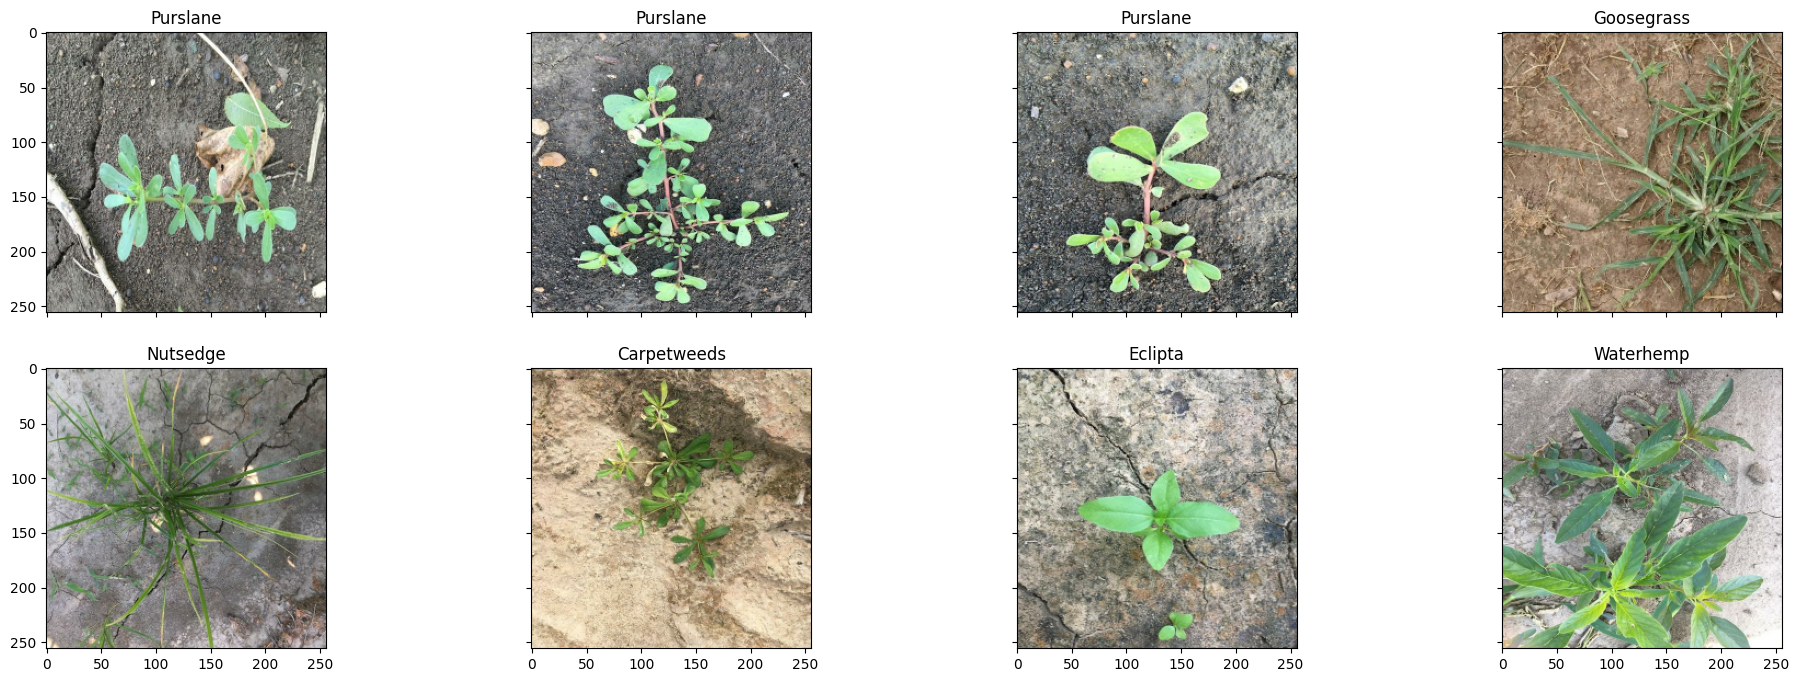

In [16]:
#image visualization
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(24,8))

for images, labels in validation_generator:
    for i in range(2):
        for j in range(4):
            ax[i][j].imshow(images[i+j*2].numpy().astype(np.int32))
            ax[i][j].set_title(id2label[np.argmax(labels[i+j*2])])

    break
plt.show()

# Pooling Schemes

In [17]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPool2D, Reshape, \
                        Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda, Average
from tensorflow.keras import backend as K
from tensorflow.keras.activations import sigmoid, softmax

class SpatialMaxPooling2D(tf.keras.layers.Layer):
    def __init__(self,pool_size=2,stride=None,padding='valid',data_format='channels_last', **kwargs):
        super(SpatialMaxPooling2D,self).__init__(**kwargs)
        self.pool_size = pool_size
        self.stride = stride
        self.padding = padding
        if stride is None:
            self.stride = self.pool_size

        self.data_format = 'channels_last' if data_format == 'channels_first' else 'channels_first'
        self.max = tf.keras.layers.MaxPool1D(self.pool_size, self.stride, padding=self.padding, data_format=self.data_format)

    def build(self,input_shape):
        self.reshape_forward = tf.keras.layers.Reshape((-1,input_shape[-1]))
        self.reshape_backward= tf.keras.layers.Reshape((input_shape[1], input_shape[2], -1))

    def call(self,x):
        x = self.reshape_forward(x)
        x = self.max(x)
        x = self.reshape_backward(x)
        return x

class SpatialAveragePooling2D(tf.keras.layers.Layer):
    def __init__(self,pool_size=2,stride=None,padding='valid',data_format='channels_last', **kwargs):
        super(SpatialAveragePooling2D,self).__init__(**kwargs)
        self.pool_size = pool_size
        self.stride = stride
        self.padding = padding
        if stride is None:
            self.stride = self.pool_size

        self.data_format = 'channels_last' if data_format == 'channels_first' else 'channels_first'
        self.avg = tf.keras.layers.AveragePooling1D(self.pool_size, self.stride, padding=self.padding, data_format=self.data_format)

    def build(self,input_shape):
        self.reshape_forward = tf.keras.layers.Reshape((-1,input_shape[-1]))
        self.reshape_backward= tf.keras.layers.Reshape((input_shape[1], input_shape[2], -1))

    def call(self,x):
        x = self.reshape_forward(x)
        x = self.avg(x)
        x = self.reshape_backward(x)
        return x

def AverageOfMaximums(x, max_pool_size=2, layer_num=1):
    _max = layers.MaxPooling2D(pool_size=max_pool_size,padding='same', name="Maximums_L{}".format(layer_num))(x)
    _avg = layers.GlobalAveragePooling2D(name="Average_of_Maximums_L{}".format(layer_num))(_max)
    return _avg

# Transformer Encoder: Global Self Attention & Point-wise Feed Forward

In [18]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()


class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x

# Building MobileNet Model

In [19]:
from tensorflow.keras.applications import MobileNet, MobileNetV2, MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.applications import EfficientNetV2S, ConvNeXtSmall

def augment(seed=42):
    return keras.Sequential([
        layers.RandomBrightness(0.3, (0, 1),seed=seed, name='RR_Bright'),
        # layers.RandomContrast(0.3, seed=seed, name='RR_Contr'), # can't run deterministically
        layers.RandomFlip(seed=seed, name='RR_Flip'),
        layers.RandomRotation(0.5, seed=seed, name='RR_Rot'),
        layers.RandomTranslation(0.4, 0.4, seed=seed, name='RR_Trans'),
        layers.RandomZoom(0.2, 0.2, seed=seed, name='RR_Zoom'),
        layers.GaussianDropout(0.01, seed=seed, name='RR_Gauss'),
    ], name='augment_pipeline')


def skipAugment(model):
    inputs = keras.Input(shape=IMG_SIZE)
    x = inputs
    for layer in model.layers:
        if 'augment' not in layer.name and 'input' not in layer.name:
            x = layer(x)

    model = keras.Model(inputs=inputs, outputs=x, name=model.name)
    return model

def hard_swish(x):
    relu6 = layers.ReLU(max_value=6)
    return x * (relu6(x + 3) / 6)

def MobilenetV3Base(img_size, use='S'): # use = S (small) or L (large)
    # Load the MobileNet model with weights pre-trained on ImageNet.
    if(use=='S'):
        mobilenet = MobileNetV3Small(input_shape=img_size, weights='imagenet')
    if(use=='L'):
        mobilenet = MobileNetV3Large(input_shape=img_size, weights='imagenet')
    mobilenet.trainable = True

    base_model =  keras.Model(inputs=mobilenet.layers[0].input, outputs=mobilenet.layers[-11].output, name = mobilenet.name+"_base_")
    base_model.trainable = True

    pooler = mobilenet.layers[-9]

    return base_model , pooler

def buildModel(IMG_SIZE):
    # Load the MobileNet model with weights pre-trained on ImageNet.
    base_model, pooler = MobilenetV3Base((224,224,3), use='S')
    base_model.trainable = True
    # out_dim = 1024 if "small" in base_model.name.lower() else 1280 if "large" in base_model.name.lower() else base_model.output.shape[-1]

    print("Base Model:", base_model.name)
    print(len(base_model.layers))
    # Define the input layer.
    inputs = keras.Input(shape=IMG_SIZE, name='input')

    # Pre-process the input.
    x = layers.Rescaling(1./255, name='PP_Rescale')(inputs)
    x = layers.Resizing(224, 224, name='PP_Resize')(x)

    x = augment(seed)(x)
    x = base_model(x, training=True)

    x = layers.GlobalAveragePooling2D(keepdims=True)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(15, activation='softmax')(x)

    model_name = "CottonWeed15-" + base_model.name
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

    return model

In [20]:
# IMG_SIZE = (256,256,3)
# seed = 42

model = buildModel(IMG_SIZE)
model.summary()

10734624/10734624 [==============================] - 1s 0us/step
Base Model: MobilenetV3small_base_
229
Model: "CottonWeed15-MobilenetV3small_base_"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 PP_Rescale (Rescaling)      (None, 256, 256, 3)       0         
                                                                 
 PP_Resize (Resizing)        (None, 224, 224, 3)       0         
                                                                 
 augment_pipeline (Sequenti  (None, 224, 224, 3)       0         
 al)                                                             
                                                                 
 MobilenetV3small_base_ (Fu  (None, 7, 7, 576)         939120    
 nctional)                                                 

In [21]:
# keras.utils.plot_model(model)

## Trial 1 - FineTuning

In [22]:
from tensorflow.keras.optimizers import Adam, AdamW

# Constant for epochs
EPOCHS = 100

pat_es = 15
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=pat_es, verbose=1, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.75, patience=3, verbose=1, min_lr=1e-6)

model.compile(loss='categorical_crossentropy',
          optimizer= AdamW(learning_rate=2e-4,  weight_decay=5e-2),
          metrics=['accuracy'])

Epoch 1/100


I0000 00:00:1717158327.719760     101 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


260/260 [==============================] - 44s 55ms/step - loss: 2.2352 - accuracy: 0.3000 - val_loss: 1.5923 - val_accuracy: 0.5227 - lr: 2.0000e-04
Epoch 2/100
260/260 [==============================] - 13s 49ms/step - loss: 1.4677 - accuracy: 0.5365 - val_loss: 0.9750 - val_accuracy: 0.6924 - lr: 2.0000e-04
Epoch 3/100
260/260 [==============================] - 13s 50ms/step - loss: 1.0740 - accuracy: 0.6505 - val_loss: 0.7355 - val_accuracy: 0.7676 - lr: 2.0000e-04
Epoch 4/100
260/260 [==============================] - 13s 49ms/step - loss: 0.8813 - accuracy: 0.7138 - val_loss: 0.6446 - val_accuracy: 0.7917 - lr: 2.0000e-04
Epoch 5/100
260/260 [==============================] - 13s 49ms/step - loss: 0.8036 - accuracy: 0.7449 - val_loss: 0.5788 - val_accuracy: 0.8206 - lr: 2.0000e-04
Epoch 6/100
260/260 [==============================] - 13s 50ms/step - loss: 0.7030 - accuracy: 0.7719 - val_loss: 0.5094 - val_accuracy: 0.8390 - lr: 2.0000e-04
Epoch 7/100
260/260 [===================

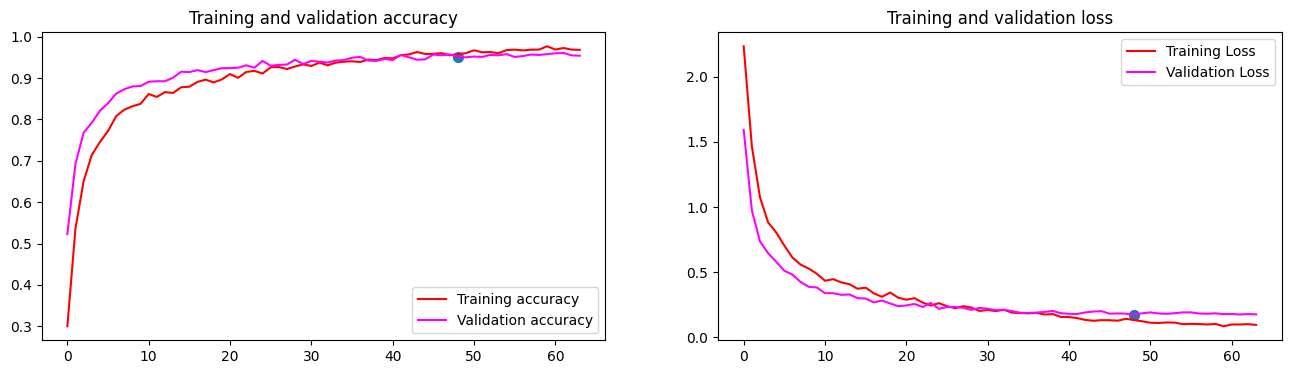

CPU times: user 28min 13s, sys: 1min 18s, total: 29min 31s
Wall time: 14min 23s


In [23]:
%%time

# Train the model
history1 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping, reduce_lr],
    )

print("Saving the Model")
model.save(model.name+".keras")

# Plot training results
plot_loss_acc(history1.history)

model.evaluate
87/87 [==============================] - 1s 14ms/step - loss: 0.1732 - accuracy: 0.9518
model.predict


  0%|          | 0/87 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

      Nutsedge    0.88679   0.97917   0.93069        48
     Sicklepod    0.95455   0.93333   0.94382        45
  Morningglory    0.96035   0.97758   0.96889       223
       Ragweed    0.91667   0.95652   0.93617        23
PalmerAmaranth    0.95620   0.92908   0.94245       141
     Waterhemp    0.92405   0.93590   0.92994        78
     Crabgrass    0.95000   0.95000   0.95000        20
    Swinecress    0.91667   0.84615   0.88000        13
  Prickly Sida    0.95455   0.75000   0.84000        28
   Carpetweeds    0.98101   0.98726   0.98413       157
 SpottedSpurge    0.94340   0.96154   0.95238        52
  SpurredAnoda    0.90909   0.90909   0.90909        11
       Eclipta    1.00000   0.94737   0.97297        57
    Goosegrass    0.97297   0.85714   0.91139        42
      Purslane    0.92453   0.98990   0.95610        99

      accuracy                        0.95178      1037
     macro avg    0.94339 

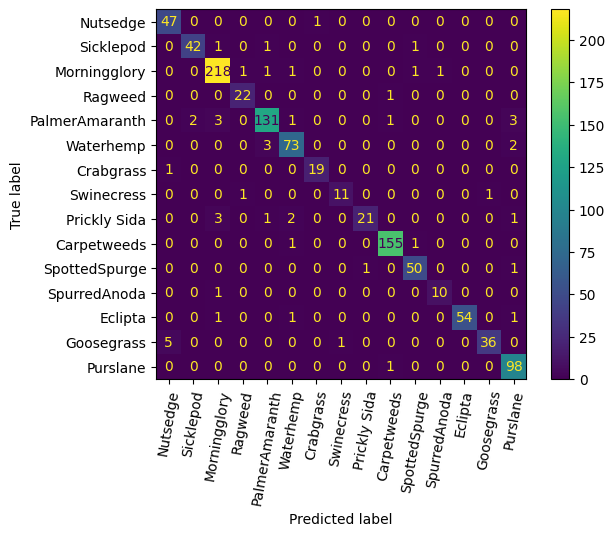

In [24]:
a, b = eval_model(model, validation_generator)

# Trial 2 - Freezing Base Model

Freezing Layer MobilenetV3small_base_
Epoch 1/100
260/260 [==============================] - 12s 26ms/step - loss: 0.5463 - accuracy: 0.8262 - val_loss: 0.3451 - val_accuracy: 0.8901 - lr: 2.0000e-04
Epoch 2/100
260/260 [==============================] - 6s 22ms/step - loss: 0.4349 - accuracy: 0.8699 - val_loss: 0.3134 - val_accuracy: 0.9036 - lr: 2.0000e-04
Epoch 3/100
260/260 [==============================] - 6s 22ms/step - loss: 0.4092 - accuracy: 0.8795 - val_loss: 0.2933 - val_accuracy: 0.9161 - lr: 2.0000e-04
Epoch 4/100
260/260 [==============================] - 6s 22ms/step - loss: 0.3844 - accuracy: 0.8876 - val_loss: 0.2870 - val_accuracy: 0.9180 - lr: 2.0000e-04
Epoch 5/100
260/260 [==============================] - 6s 24ms/step - loss: 0.3647 - accuracy: 0.8924 - val_loss: 0.2819 - val_accuracy: 0.9161 - lr: 2.0000e-04
Epoch 6/100
260/260 [==============================] - 6s 22ms/step - loss: 0.3492 - accuracy: 0.8927 - val_loss: 0.2768 - val_accuracy: 0.9171 - lr: 2.0000

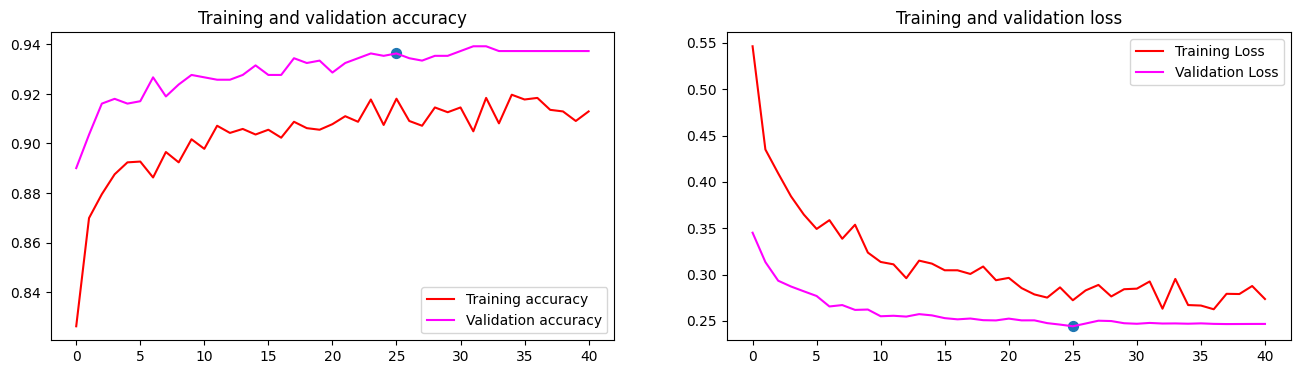

CPU times: user 12min 32s, sys: 37.3 s, total: 13min 10s
Wall time: 4min 10s


In [25]:
%%time
# weights = getWeightedClass(data_info, 1/2)
# print("Using Class-Weights",weights)
# model = skipAugment(model)
for layer in model.layers:
    if('mobilenet' in layer.name.lower()):
        print("Freezing Layer", layer.name)
        layer.trainable = False
        break

model.compile(loss='categorical_crossentropy',
    optimizer= AdamW(learning_rate=2e-4,  weight_decay=5e-2),
    metrics=['accuracy'])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=3, verbose=1, min_lr=1e-8)
# Train the model
history2 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping, reduce_lr],
    )

print("Saving the Model")
model.save(model.name+".keras")

# Plot training results
plot_loss_acc(history2.history)

## Evaluations

Total Epochs: range(0, 105)


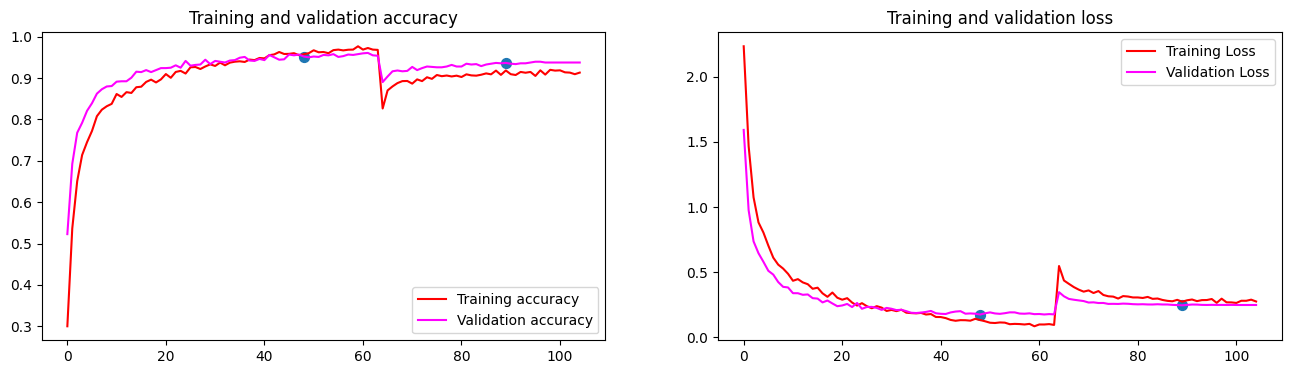

In [26]:
import copy

history = copy.deepcopy(history1.history)

for key in history:
    history[key].extend(history2.history[key])


h1len = len(history1.history['accuracy'])
h2len = len(history2.history['accuracy'])

pat_es +=1
history['peaks'] = [h1len-pat_es, (h1len+h2len)-pat_es]
history['peaks'] = [i if i>=0 else 0 for i in history['peaks']]

plot_loss_acc(history)

Total Epochs: range(0, 64)


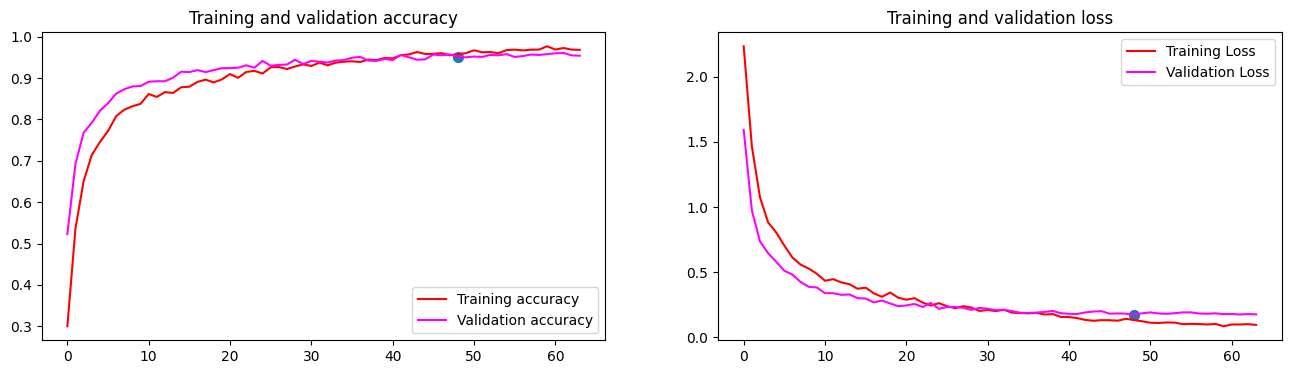

Total Epochs: range(0, 41)


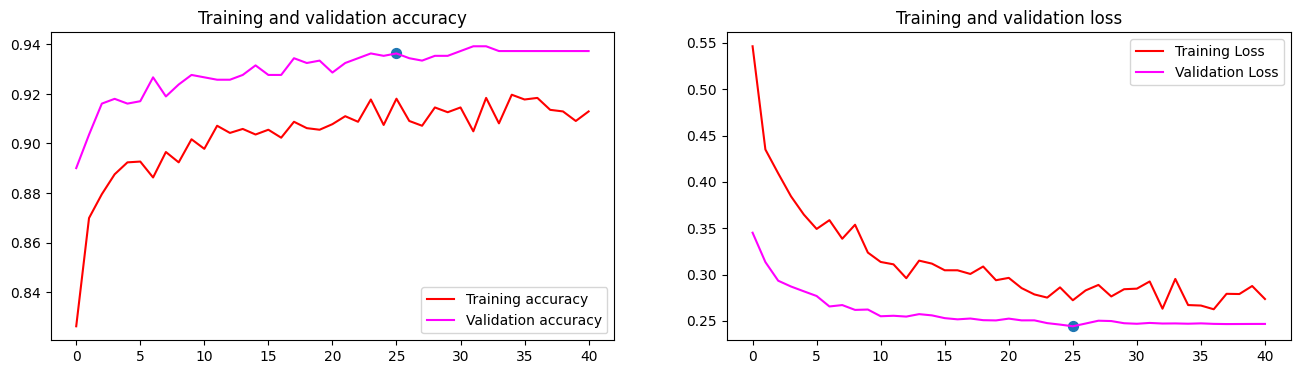

In [27]:
plot_loss_acc(history1.history)
plot_loss_acc(history2.history)

model.evaluate
87/87 [==============================] - 1s 14ms/step - loss: 0.2441 - accuracy: 0.9364
model.predict


  0%|          | 0/87 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

      Nutsedge    0.85714   1.00000   0.92308        48
     Sicklepod    0.91489   0.95556   0.93478        45
  Morningglory    0.96000   0.96861   0.96429       223
       Ragweed    0.91667   0.95652   0.93617        23
PalmerAmaranth    0.91156   0.95035   0.93056       141
     Waterhemp    0.92308   0.92308   0.92308        78
     Crabgrass    0.94444   0.85000   0.89474        20
    Swinecress    0.90909   0.76923   0.83333        13
  Prickly Sida    1.00000   0.60714   0.75556        28
   Carpetweeds    0.95570   0.96178   0.95873       157
 SpottedSpurge    1.00000   0.88462   0.93878        52
  SpurredAnoda    1.00000   0.72727   0.84211        11
       Eclipta    0.98214   0.96491   0.97345        57
    Goosegrass    0.97222   0.83333   0.89744        42
      Purslane    0.88182   0.97980   0.92823        99

      accuracy                        0.93635      1037
     macro avg    0.94192 

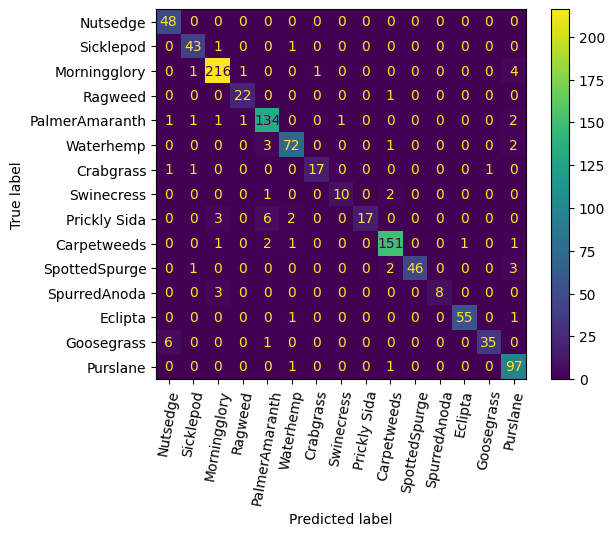

In [28]:
## Computing Positive Threshold Using Validation Dataset

a, b = eval_model(model,validation_generator)

### Test Set Evaluation

model.evaluate
87/87 [==============================] - 1s 13ms/step - loss: 0.1978 - accuracy: 0.9335
model.predict


  0%|          | 0/87 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

      Nutsedge    0.91667   1.00000   0.95652        55
     Sicklepod    0.84000   0.87500   0.85714        48
  Morningglory    0.97260   0.95516   0.96380       223
       Ragweed    1.00000   0.96000   0.97959        25
PalmerAmaranth    0.89041   0.94203   0.91549       138
     Waterhemp    0.89583   0.95556   0.92473        90
     Crabgrass    0.92000   1.00000   0.95833        23
    Swinecress    0.92857   0.92857   0.92857        14
  Prickly Sida    0.90000   0.69231   0.78261        26
   Carpetweeds    0.97945   0.94079   0.95973       152
 SpottedSpurge    0.95833   0.97872   0.96842        47
  SpurredAnoda    0.88889   0.66667   0.76190        12
       Eclipta    0.90909   0.78431   0.84211        51
    Goosegrass    0.97561   0.93023   0.95238        43
      Purslane    0.91579   0.96667   0.94054        90

      accuracy                        0.93346      1037
     macro avg    0.92608 

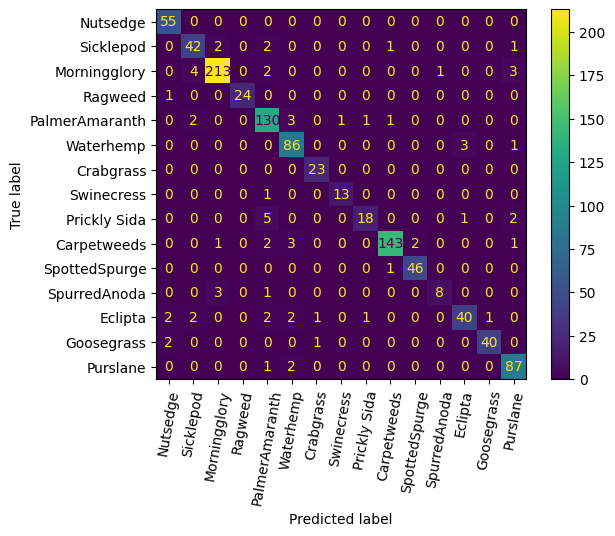

In [29]:
a, b = eval_model(model, test_generator)

In [30]:
shutil.rmtree(base_dir)